<a name='1'></a>

# table of contents
- [ 1 - Table of contents](#1)
- [ 2 - Imports](#2)
- [ 3 - Reading data](#3)
- [ 4 - bivariate analysis numerical](#4)
- [ 5 - bivariate analysis categorical](#5)
- [ 6 - Inf treat](#6)
- [ 7 - Booking slot](#7)
- [ 8 - split](#8)
- [ 9 - train](#9)
  - [ 9.1 - Using oversample](#9.1)
  
  
 ## refrences
 
 - similar problem in appointment booking in health services
 - datasets usually in the range of 120k 
 - no show rate around ~14%
 - algorithms mainly used logistic regression ,boosting 
 - avg variables in the final model was 17, main variables - lead time, prev no show, distance ,patient age
 
 
 - https://www.mdpi.com/2078-2489/13/11/507
 - https://bmchealthservres.biomedcentral.com/articles/10.1186/s12913-023-10418-6
 - https://www.nature.com/articles/s41746-022-00594-w

<a name='2'></a>
# imports

In [1]:
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',76)
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


<a name='3'></a>
# Reading data

In [3]:
df = pd.read_csv('data_assignment.gz', compression='gzip')

In [4]:
#data is imbalanced
df["ns"].value_counts(normalize="True")*100

ns
0    96.915742
1     3.084258
Name: proportion, dtype: float64

In [5]:
df.shape

(181859, 75)

In [6]:
#data has no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181859 entries, 0 to 181858
Data columns (total 75 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        181859 non-null  object 
 1   provider_id                     181859 non-null  object 
 2   is_exclusive_lead               181859 non-null  int64  
 3   bookingslot                     181859 non-null  object 
 4   ns_count_1day                   181859 non-null  int64  
 5   ns_count_3day                   181859 non-null  int64  
 6   ns_count_1week                  181859 non-null  int64  
 7   ns_count_1month                 181859 non-null  int64  
 8   ns_count_6month                 181859 non-null  int64  
 9   responded_lead_1day             181859 non-null  int64  
 10  responded_lead_3day             181859 non-null  int64  
 11  responded_lead_1week            181859 non-null  int64  
 12  responded_lead_1

In [7]:
#data has multiple categorical and categorical numerical values
df

,order_id,provider_id,is_exclusive_lead,bookingslot,ns_count_1day,ns_count_3day,ns_count_1week,ns_count_1month,ns_count_6month,responded_lead_1day,responded_lead_3day,responded_lead_1week,responded_lead_1month,responded_lead_3month,responded_lead_6month,paf_count_1day,paf_count_3day,paf_count_1week,paf_count_1month,paf_count_6month,delivered_lead_1day,delivered_lead_3day,delivered_lead_1week,delivered_lead_1month,delivered_lead_3month,delivered_lead_6month,service_delivery_rate_1day,service_delivery_rate_3day,service_delivery_rate_1week,service_delivery_rate_1month,service_delivery_rate_3month,service_delivery_rate_6month,Acceptance_Rate_1DAY,Acceptance_Rate_3DAY,Acceptance_Rate_1WEEK,Acceptance_Rate_1MONTH,Acceptance_Rate_3MONTH,Acceptance_Rate_6MONTH,pro_rating_1day,pro_rating_3day,pro_rating_1week,pro_rating_1month,pro_rating_3month,pro_rating_6month,total_income_1day,total_income_3day,total_income_1week,total_income_1month,total_income_3month,total_income_6month,days_no_block_in_1day,days_block_in_1day,number_times_blocked_in_1day,days_no_block_in_3day,days_block_in_3day,number_times_blocked_in_3day,days_no_block_in_1week,days_block_in_1week,number_times_blocked_in_1week,days_no_block_in_1month,days_block_in_1month,number_times_blocked_in_1month,days_no_block_in_3month,days_block_in_3month,number_times_blocked_in_3month,days_no_block_in_6month,days_block_in_6month,number_times_blocked_in_6month,avg_order_value_1day,avg_order_value_3day,avg_order_value_1week,avg_order_value_1month,avg_order_value_3month,avg_order_value_6month,ns
0,62107eff2938da280068c2c9,5e37b5f496d3362500c710d4,0,AfterNoon,0,0,0,1,5,2,6,13,32,97,223,1,1,2,6,44,1,5,11,26,75,179,0.500000,0.833333,0.846154,0.812500,0.773196,0.802691,3.00,1.500000,1.600000,1.517241,1.886076,1.899471,5.000000,5.000000,4.875000,4.843750,4.793478,4.785714,306.139956,1877.392747,5087.570615,14710.611406,38404.455871,94234.582247,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,178,2,1,0.0,157.833333,352.923077,479.406250,399.288660,363.672646,0
1,62107eff2938da280068c2c9,5e58e2df14f8c026008e454a,0,AfterNoon,0,0,0,1,4,2,7,15,66,161,310,1,2,3,10,76,1,5,12,56,130,234,0.500000,0.714286,0.800000,0.848485,0.807453,0.754839,2.50,1.500000,2.000000,1.650000,1.676692,1.712500,5.000000,4.750000,4.875000,4.725806,4.741667,4.745614,357.476152,2028.609741,5827.121124,22248.825965,52708.768094,98110.364274,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,180,0,0,372.0,302.857143,382.400000,421.212121,384.906832,347.167742,0
2,62107eff2938da280068c2c9,5f7182270446792500c1005a,0,AfterNoon,0,0,1,1,1,3,5,10,35,97,212,2,3,4,7,36,1,2,6,28,79,176,0.333333,0.400000,0.600000,0.800000,0.814433,0.830189,1.00,1.000000,1.000000,1.033333,1.087500,1.279330,4.500000,4.500000,4.833333,4.900000,4.882353,4.739130,359.154094,776.514019,2779.203630,10287.248557,24786.740728,55636.160136,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,180,0,0,249.0,149.400000,411.800000,339.971429,273.268041,225.731132,0
3,62107eff2938da280068c2c9,5f0c7eb39eb3c12500d7af80,0,AfterNoon,0,0,0,1,19,2,7,22,76,215,480,1,4,8,28,184,1,3,14,48,128,296,0.500000,0.428571,0.636364,0.631579,0.595349,0.616667,1.00,1.200000,1.214286,1.250000,1.500000,1.692308,5.000000,5.000000,5.000000,4.988636,4.995798,4.958929,424.799899,1421.109832,6113.908648,19690.453213,53846.316431,121950.264014,1,0,0,3,0,0,7,0,0,30,0,0,89,0,0,179,0,0,0.0,406.285714,255.181818,342.552632,422.446512,386.900000,0
4,6210830ba014f82a00115ca2,59f8630a8378405d001603d0,0,AfterNoon,0,0,0,0,1,2,7,20,89,290,538,1,2,5,21,138,1,5,15,68,219,400,0.500000,0.714286,0.750000,0.764045,0.755172,0.743494,1.00,1.200000,1.266667,1.208955,1.221198,1.189526,3.000000,4.000000,4.714286,4.522727,4.632812,4.719136,41.890533,1015.611112,1728.688877,16299.584613,54323.306404,97842.801498,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,180,0,0,114.5,162.428571,183.400000,186.033708,162.231034,169.665428,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [8]:
# df.to_excel('uc_data.xlsx',index=False)

In [9]:
len(df.order_id.unique())

122917

In [10]:
len(df.provider_id.unique())

17065

In [11]:
df["provider_id"].value_counts(normalize="True")*100

provider_id
6192610a19024728005d8176    0.139669
5efda4ec641bf72c0005345a    0.137469
5c29edc377129b21002d4c2d    0.137469
5cb188c017c63e240039e6da    0.126472
605ee9c03e30c92800cef1ce    0.124272
                              ...   
5e156642f8e90a2400de840c    0.000550
61285b28cac66a280057af91    0.000550
5f66084414420d2900070103    0.000550
5d8c8c66f5bad32600699580    0.000550
614cc3942ac96d2a00d31e44    0.000550
Name: proportion, Length: 17065, dtype: float64

In [12]:
df["order_id"].value_counts(normalize="True")*100

order_id
61f50b4814aadd28008d54d2    0.019246
61e9581240dcad280073d2be    0.015946
61f51a480afe9f2800b9fcfe    0.015946
61ce8c9121d9c72400870c56    0.014847
61b39226e2ff3725007d9cde    0.014847
                              ...   
61e8feaa12aa612a0078d3fe    0.000550
61e947ad8ebca026002c9d7f    0.000550
61e909768c6b642a00faadce    0.000550
61e8d2ca07d65f28007ff027    0.000550
61a653772b453d28004fe049    0.000550
Name: proportion, Length: 122917, dtype: float64

<a name='4'></a>
# bivariate analysis numerical

In [13]:
def get_bins_and_no_show_percentage(df, column, target_column, num_bins=5):
    bins = np.linspace(df[column].min(), df[column].max(), num_bins+1)
    df['bin'] = pd.cut(df[column], bins=bins, include_lowest=True,duplicates="drop")
    bin_counts = df['bin'].value_counts()
    bin_percentages = (bin_counts / len(df)) * 100
    no_show_percentages = df.groupby('bin')[target_column].mean() * 100
    result_df = pd.DataFrame({
            'Bin Counts': bin_counts,
            'Bin Percentages': bin_percentages,
            'No Show Percentages': no_show_percentages
        }).reset_index().rename(columns={'index': 'Bin'})
        
    return result_df

cols=['ns_count_1day', 'ns_count_3day', 'ns_count_1week', 'ns_count_1month',
       'ns_count_6month', 'responded_lead_1day', 'responded_lead_3day',
       'responded_lead_1week', 'responded_lead_1month',
       'responded_lead_3month', 'responded_lead_6month', 'paf_count_1day',
       'paf_count_3day', 'paf_count_1week', 'paf_count_1month',
       'paf_count_6month', 'delivered_lead_1day', 'delivered_lead_3day',
       'delivered_lead_1week', 'delivered_lead_1month',
       'delivered_lead_3month', 'delivered_lead_6month',
       'service_delivery_rate_1day', 'service_delivery_rate_3day',
       'service_delivery_rate_1week', 'service_delivery_rate_1month',
       'service_delivery_rate_3month', 'service_delivery_rate_6month',
#        'Acceptance_Rate_1DAY', 'Acceptance_Rate_3DAY', 'Acceptance_Rate_1WEEK',
       'Acceptance_Rate_1MONTH', 'Acceptance_Rate_3MONTH',
       'Acceptance_Rate_6MONTH', 'pro_rating_1day', 'pro_rating_3day',
       'pro_rating_1week', 'pro_rating_1month', 'pro_rating_3month',
       'pro_rating_6month', 'total_income_1day', 'total_income_3day',
       'total_income_1week', 'total_income_1month', 'total_income_3month',
       'total_income_6month', 'days_no_block_in_1day', 'days_block_in_1day',
       'number_times_blocked_in_1day', 'days_no_block_in_3day',
       'days_block_in_3day', 'number_times_blocked_in_3day',
       'days_no_block_in_1week', 'days_block_in_1week',
       'number_times_blocked_in_1week', 'days_no_block_in_1month',
       'days_block_in_1month', 'number_times_blocked_in_1month',
       'days_no_block_in_3month', 'days_block_in_3month',
       'number_times_blocked_in_3month', 'days_no_block_in_6month',
       'days_block_in_6month', 'number_times_blocked_in_6month',
       'avg_order_value_1day', 'avg_order_value_3day', 'avg_order_value_1week',
       'avg_order_value_1month', 'avg_order_value_3month',
       'avg_order_value_6month']
for x in cols:
    result = get_bins_and_no_show_percentage(df, x, 'ns')
    print(x)
    print(f"{result} \n")

ns_count_1day
             bin  Bin Counts  Bin Percentages  No Show Percentages
0  (-0.001, 1.4]      180800        99.417681             3.052544
1     (1.4, 2.8]         945         0.519633             7.830688
2     (2.8, 4.2]          98         0.053888            13.265306
3     (4.2, 5.6]           7         0.003849            14.285714
4     (5.6, 7.0]           9         0.004949            22.222222 

ns_count_3day
             bin  Bin Counts  Bin Percentages  No Show Percentages
0  (-0.001, 3.0]      180955        99.502912             3.062640
1     (3.0, 6.0]         603         0.331576             7.296849
2     (6.0, 9.0]         286         0.157265             6.293706
3    (9.0, 12.0]           9         0.004949            22.222222
4   (12.0, 15.0]           6         0.003299            50.000000 

ns_count_1week
             bin  Bin Counts  Bin Percentages  No Show Percentages
0  (-0.001, 5.0]      180500        99.252718             3.051524
1    (5.0, 10.0

delivered_lead_3month
               bin  Bin Counts  Bin Percentages  No Show Percentages
0   (0.999, 220.2]      138274        76.033630             3.440271
1   (220.2, 439.4]       42408        23.319165             1.935955
2   (439.4, 658.6]         918         0.504787             2.178649
3   (658.6, 877.8]         121         0.066535             4.132231
4  (877.8, 1097.0]         138         0.075883             4.347826 

delivered_lead_6month
                bin  Bin Counts  Bin Percentages  No Show Percentages
0    (0.999, 296.0]      102513        56.369495             3.706847
1    (296.0, 591.0]       66170        36.385331             2.348496
2    (591.0, 886.0]       12487         6.866309             1.841916
3   (886.0, 1181.0]         634         0.348622             3.943218
4  (1181.0, 1476.0]          55         0.030243             0.000000 

service_delivery_rate_1day
              bin  Bin Counts  Bin Percentages  No Show Percentages
0   (0.11, 0.275]      

total_income_1week
                      bin  Bin Counts  Bin Percentages  No Show Percentages
0  (-5863.899, 12223.013]      164383        90.390357             3.162736
1  (12223.013, 30309.923]       16692         9.178539             2.372394
2  (30309.923, 48396.833]         647         0.355770             2.163833
3  (48396.833, 66483.743]         131         0.072034             0.000000
4  (66483.743, 84570.654]           6         0.003299             0.000000 

total_income_1month
                        bin  Bin Counts  Bin Percentages  No Show Percentages
0    (-7136.885, 50623.838]      170061        93.512556             3.146518
1   (50623.838, 108384.559]       10987         6.041494             2.257213
2  (108384.559, 166145.281]         646         0.355220             1.393189
3  (166145.281, 223906.002]         130         0.071484             0.000000
4  (223906.002, 281666.724]          35         0.019246             2.857143 

total_income_3month
             

In [14]:
df.isnull().sum()

order_id                          0
provider_id                       0
is_exclusive_lead                 0
bookingslot                       0
ns_count_1day                     0
ns_count_3day                     0
ns_count_1week                    0
ns_count_1month                   0
ns_count_6month                   0
responded_lead_1day               0
responded_lead_3day               0
responded_lead_1week              0
responded_lead_1month             0
responded_lead_3month             0
responded_lead_6month             0
paf_count_1day                    0
paf_count_3day                    0
paf_count_1week                   0
paf_count_1month                  0
paf_count_6month                  0
delivered_lead_1day               0
delivered_lead_3day               0
delivered_lead_1week              0
delivered_lead_1month             0
delivered_lead_3month             0
delivered_lead_6month             0
service_delivery_rate_1day        0
service_delivery_rate_3day  

In [15]:
def count_inf(df):
    # Count infinity values in each column
    inf_counts = df.isin([float('inf'), -float('inf')]).sum()

    return inf_counts


inf=count_inf(df)
inf

order_id                             0
provider_id                          0
is_exclusive_lead                    0
bookingslot                          0
ns_count_1day                        0
ns_count_3day                        0
ns_count_1week                       0
ns_count_1month                      0
ns_count_6month                      0
responded_lead_1day                  0
responded_lead_3day                  0
responded_lead_1week                 0
responded_lead_1month                0
responded_lead_3month                0
responded_lead_6month                0
paf_count_1day                       0
paf_count_3day                       0
paf_count_1week                      0
paf_count_1month                     0
paf_count_6month                     0
delivered_lead_1day                  0
delivered_lead_3day                  0
delivered_lead_1week                 0
delivered_lead_1month                0
delivered_lead_3month                0
delivered_lead_6month    

<a name='5'></a>

# bivariate analysis categorical

In [16]:
def analyze_categorical_column(df, column, target_column='NoShow'):
    
    result_df = df.groupby(column)[target_column].agg([
        ('Count', 'count'),
        ('Percentage', lambda x: (len(x) / len(df)) * 100),
        ('NoShow Percentage', lambda x: (x.sum() / len(x)) * 100)
    ]).reset_index()
    result_df = result_df.sort_values(by='NoShow Percentage', ascending=False)
    return result_df
    
    

for x in df.columns[2:4]:    
    results=analyze_categorical_column(df,x,"ns")
    print(x)
    print(f"{results} \n")


is_exclusive_lead
   is_exclusive_lead  Count  Percentage  NoShow Percentage
0                  0  91562   50.347797           4.082480
1                  1  90297   49.652203           2.072051 

bookingslot
  bookingslot  Count  Percentage  NoShow Percentage
2     Morning  26138   14.372673           4.246691
3       Night   1528    0.840211           3.337696
1     Evening  54373   29.898438           3.187244
0   AfterNoon  99820   54.888677           2.719896 



In [17]:
# df[cols].corr().to_excel("uc_corr.xlsx")

In [18]:
corr_matrix = df[cols].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(100, 120))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [19]:
#after checking correlation you can see 3day and 3 month are correlated with most of the values, so taking only 3days and 3 months

In [20]:
three_months=[i for i in df.columns if '3month' in i]
three_days=[i for i in df.columns if '3day' in i]
three_cols=three_months+three_days
three_cols.append('Acceptance_Rate_3MONTH')
three_cols.append('Acceptance_Rate_3DAY')

In [21]:
print(three_cols)
print(len(three_cols))

['responded_lead_3month', 'delivered_lead_3month', 'service_delivery_rate_3month', 'pro_rating_3month', 'total_income_3month', 'days_no_block_in_3month', 'days_block_in_3month', 'number_times_blocked_in_3month', 'avg_order_value_3month', 'ns_count_3day', 'responded_lead_3day', 'paf_count_3day', 'delivered_lead_3day', 'service_delivery_rate_3day', 'pro_rating_3day', 'total_income_3day', 'days_no_block_in_3day', 'days_block_in_3day', 'number_times_blocked_in_3day', 'avg_order_value_3day', 'Acceptance_Rate_3MONTH', 'Acceptance_Rate_3DAY']
22


In [22]:
three_months

['responded_lead_3month',
 'delivered_lead_3month',
 'service_delivery_rate_3month',
 'pro_rating_3month',
 'total_income_3month',
 'days_no_block_in_3month',
 'days_block_in_3month',
 'number_times_blocked_in_3month',
 'avg_order_value_3month']

In [23]:
three_days

['ns_count_3day',
 'responded_lead_3day',
 'paf_count_3day',
 'delivered_lead_3day',
 'service_delivery_rate_3day',
 'pro_rating_3day',
 'total_income_3day',
 'days_no_block_in_3day',
 'days_block_in_3day',
 'number_times_blocked_in_3day',
 'avg_order_value_3day']

In [24]:
final_cols=three_cols+['paf_count_6month','ns_count_6month','bookingslot','is_exclusive_lead','ns']
final_cols

['responded_lead_3month',
 'delivered_lead_3month',
 'service_delivery_rate_3month',
 'pro_rating_3month',
 'total_income_3month',
 'days_no_block_in_3month',
 'days_block_in_3month',
 'number_times_blocked_in_3month',
 'avg_order_value_3month',
 'ns_count_3day',
 'responded_lead_3day',
 'paf_count_3day',
 'delivered_lead_3day',
 'service_delivery_rate_3day',
 'pro_rating_3day',
 'total_income_3day',
 'days_no_block_in_3day',
 'days_block_in_3day',
 'number_times_blocked_in_3day',
 'avg_order_value_3day',
 'Acceptance_Rate_3MONTH',
 'Acceptance_Rate_3DAY',
 'paf_count_6month',
 'ns_count_6month',
 'bookingslot',
 'is_exclusive_lead',
 'ns']

In [25]:
len(final_cols)

27

<a name='6'></a>

# treating infinity values with median

In [26]:
df[df['Acceptance_Rate_3DAY']==np.inf]['ns'].value_counts()

ns
0    42
1     2
Name: count, dtype: int64

In [27]:
df['Acceptance_Rate_3DAY'].median()

1.2727272727272727

In [28]:
final_df=df[final_cols]


In [29]:
inf=count_inf(final_df)
inf

responded_lead_3month              0
delivered_lead_3month              0
service_delivery_rate_3month       0
pro_rating_3month                  0
total_income_3month                0
days_no_block_in_3month            0
days_block_in_3month               0
number_times_blocked_in_3month     0
avg_order_value_3month             0
ns_count_3day                      0
responded_lead_3day                0
paf_count_3day                     0
delivered_lead_3day                0
service_delivery_rate_3day         0
pro_rating_3day                    0
total_income_3day                  0
days_no_block_in_3day              0
days_block_in_3day                 0
number_times_blocked_in_3day       0
avg_order_value_3day               0
Acceptance_Rate_3MONTH             0
Acceptance_Rate_3DAY              44
paf_count_6month                   0
ns_count_6month                    0
bookingslot                        0
is_exclusive_lead                  0
ns                                 0
d

In [30]:
def replace_inf(df,col):
    df[col].replace(-np.inf,df[col].median(),inplace=True)
    df[col].replace(np.inf,df[col].median(),inplace=True)
    return df

final_inf_df=replace_inf(final_df,'Acceptance_Rate_3DAY')
inf=count_inf(final_inf_df)
inf

responded_lead_3month             0
delivered_lead_3month             0
service_delivery_rate_3month      0
pro_rating_3month                 0
total_income_3month               0
days_no_block_in_3month           0
days_block_in_3month              0
number_times_blocked_in_3month    0
avg_order_value_3month            0
ns_count_3day                     0
responded_lead_3day               0
paf_count_3day                    0
delivered_lead_3day               0
service_delivery_rate_3day        0
pro_rating_3day                   0
total_income_3day                 0
days_no_block_in_3day             0
days_block_in_3day                0
number_times_blocked_in_3day      0
avg_order_value_3day              0
Acceptance_Rate_3MONTH            0
Acceptance_Rate_3DAY              0
paf_count_6month                  0
ns_count_6month                   0
bookingslot                       0
is_exclusive_lead                 0
ns                                0
dtype: int64

<a name='7'></a>

# encoding booking slot

In [31]:
ordinal_encoder = OrdinalEncoder(categories=[['Morning', 'AfterNoon', 'Evening', 'Night']])
final_inf_df['bookingslot'] = ordinal_encoder.fit_transform(final_inf_df[['bookingslot']])
final_inf_df['bookingslot'].value_counts(normalize=True)

bookingslot
1.0    0.548887
2.0    0.298984
0.0    0.143727
3.0    0.008402
Name: proportion, dtype: float64

In [32]:
final_inf_df

,responded_lead_3month,delivered_lead_3month,service_delivery_rate_3month,pro_rating_3month,total_income_3month,days_no_block_in_3month,days_block_in_3month,number_times_blocked_in_3month,avg_order_value_3month,ns_count_3day,responded_lead_3day,paf_count_3day,delivered_lead_3day,service_delivery_rate_3day,pro_rating_3day,total_income_3day,days_no_block_in_3day,days_block_in_3day,number_times_blocked_in_3day,avg_order_value_3day,Acceptance_Rate_3MONTH,Acceptance_Rate_3DAY,paf_count_6month,ns_count_6month,bookingslot,is_exclusive_lead,ns
0,97,75,0.773196,4.793478,38404.455871,90,0,0,399.288660,0,6,1,5,0.833333,5.000000,1877.392747,3,0,0,157.833333,1.886076,1.500000,44,5,1.0,0,0
1,161,130,0.807453,4.741667,52708.768094,90,0,0,384.906832,0,7,2,5,0.714286,4.750000,2028.609741,3,0,0,302.857143,1.676692,1.500000,76,4,1.0,0,0
2,97,79,0.814433,4.882353,24786.740728,90,0,0,273.268041,0,5,3,2,0.400000,4.500000,776.514019,3,0,0,149.400000,1.087500,1.000000,36,1,1.0,0,0
3,215,128,0.595349,4.995798,53846.316431,89,0,0,422.446512,0,7,4,3,0.428571,5.000000,1421.109832,3,0,0,406.285714,1.500000,1.200000,184,19,1.0,0,0
4,290,219,0.755172,4.632812,54323.306404,90,0,0,162.231034,0,7,2,5,0.714286,4.000000,1015.611112,3,0,0,162.428571,1.221198,1.200000,138,1,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181854,190,117,0.615789,4.814516,92344.608055,76,14,4,306.210526,0,6,5,1,0.166667,5.000000,721.599925,3,0,0,0.000000,2.924370,1.500000,130,5,1.0,1,0
181855,165,136,0.824242,4.855670,102801.452700,90,0,0,689.587879,0,7,2,5,0.714286,5.000000,2103.469289,3,0,0,337.857143,1.605839,2.000000,53,4,0.0,0,0
181856,331,276,0.833837,4.937500,56065.376354,81,9,2,123.558912,0,14,1,13,0.928571,4.944444,2760.203274,3,0,0,222.000000,1.096154,1.153846,108,4,0.0,1,0
181857,576,417,0.723958,4.958661,100415.025356,90,0,0,286.413194,0,19,4,15,0.789474,5.000000,2006.989137,3,0,0,127.157895,1.122549,1.142857,220,4,1.0,0,0


<a name='8'></a>

# split

In [33]:
y=final_inf_df['ns']
X=final_inf_df.drop('ns',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=104,test_size=0.3,shuffle=True) 

In [34]:
print(y_train.shape)
print(y_train.value_counts(normalize=True))
print(y_test.shape)
print(y_test.value_counts(normalize=True))

(127301,)
ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64
(54558,)
ns
0    0.968749
1    0.031251
Name: proportion, dtype: float64


# Imbalanced treatment

In [35]:
y_train.value_counts()

ns
0    123397
1      3904
Name: count, dtype: int64

## Oversampling

In [36]:
os =  RandomOverSampler(sampling_strategy=0.11)
X_train_upsample, y_train_upsample = os.fit_resample(X_train, y_train)
print(f'Original dataset shape {y_train.value_counts(normalize=True)}, {y_train.value_counts()} \n')
print(f'Resampled dataset shape {y_train_upsample.value_counts(normalize=True)}, {y_train_upsample.value_counts()}' )

Original dataset shape ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64, ns
0    123397
1      3904
Name: count, dtype: int64 

Resampled dataset shape ns
0    0.900905
1    0.099095
Name: proportion, dtype: float64, ns
0    123397
1     13573
Name: count, dtype: int64


## Undersampling

In [37]:
rus = RandomUnderSampler(sampling_strategy=.11, random_state=42)
X_train_downsample, y_train_downsample = rus.fit_resample(X_train, y_train)
print(f'Original dataset shape {y_train.value_counts(normalize=True)}, {y_train.value_counts()} \n')
print(f'Resampled dataset shape {y_train_downsample.value_counts(normalize=True)}, {y_train_downsample.value_counts()}')

Original dataset shape ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64, ns
0    123397
1      3904
Name: count, dtype: int64 

Resampled dataset shape ns
0    0.900899
1    0.099101
Name: proportion, dtype: float64, ns
0    35490
1     3904
Name: count, dtype: int64


## SMOTE

In [38]:
smote = SMOTE(sampling_strategy=0.11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'Original dataset shape {y_train.value_counts(normalize=True)}, {y_train.value_counts()} \n')
print(f'Resampled dataset shape {y_train_smote.value_counts(normalize=True)}, {y_train_smote.value_counts()}')

Original dataset shape ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64, ns
0    123397
1      3904
Name: count, dtype: int64 

Resampled dataset shape ns
0    0.900905
1    0.099095
Name: proportion, dtype: float64, ns
0    123397
1     13573
Name: count, dtype: int64


# Scaling

In [39]:
scaler = StandardScaler()
feature_cols=X_train.columns

# Create copies of the original data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Apply scaling to the feature columns in the training and test sets
X_train_scaled[feature_cols] = scaler.fit_transform(X_train[feature_cols])
X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])

In [40]:
# Create copies of the resampled data
train_upsampled_scaled = X_train_upsample.copy()
train_downsampled_scaled = X_train_downsample.copy()
train_smote_scaled = X_train_smote.copy()

# Apply scaling to the feature columns in the resampled datasets
train_upsampled_scaled[feature_cols] = scaler.transform(X_train_upsample[feature_cols])
train_downsampled_scaled[feature_cols] = scaler.transform(X_train_downsample[feature_cols])
train_smote_scaled[feature_cols] = scaler.transform(X_train_smote[feature_cols])

In [41]:
# Define a function to check if the mean is close to 0 and the standard deviation is close to 1
def check_scaling(df, cols_to_scale):
    return all(np.isclose(df[col].mean(), 0, atol=2e-1) and np.isclose(df[col].std(), 1, atol=2e-1) for col in cols_to_scale)

# List of feature columns to scale
feature_cols = X_train.columns

# Perform the sanity check on all datasets
print("Sanity check for original scaled training set:", check_scaling(X_train_scaled, feature_cols))
print("Sanity check for scaled test set:", check_scaling(X_test_scaled, feature_cols))
print("Sanity check for scaled upsampled set:", check_scaling(train_upsampled_scaled, feature_cols))
print("Sanity check for scaled downsampled set:", check_scaling(train_downsampled_scaled, feature_cols))
print("Sanity check for scaled SMOTE set:", check_scaling(train_smote_scaled, feature_cols))

Sanity check for original scaled training set: True
Sanity check for scaled test set: True
Sanity check for scaled upsampled set: True
Sanity check for scaled downsampled set: True
Sanity check for scaled SMOTE set: True


# feature selection

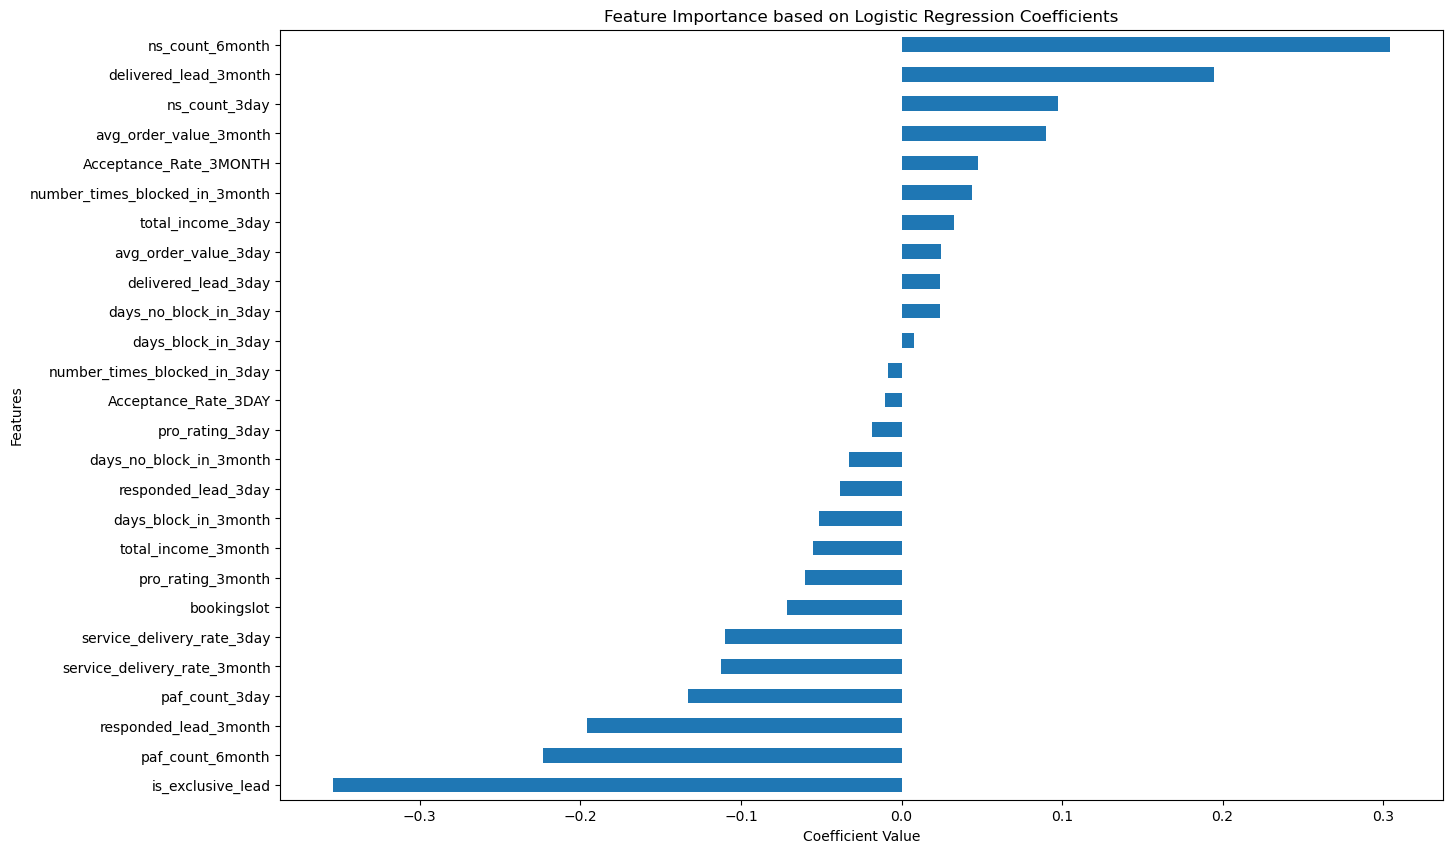

Important features based on Logistic Regression:
                                Coefficient
responded_lead_3month             -0.195666
delivered_lead_3month              0.194542
service_delivery_rate_3month      -0.112503
pro_rating_3month                 -0.060015
total_income_3month               -0.055307
days_no_block_in_3month           -0.032861
days_block_in_3month              -0.051485
number_times_blocked_in_3month     0.043695
avg_order_value_3month             0.089717
ns_count_3day                      0.097314
responded_lead_3day               -0.038087
paf_count_3day                    -0.133106
delivered_lead_3day                0.024156
service_delivery_rate_3day        -0.110235
pro_rating_3day                   -0.018283
total_income_3day                  0.032371
days_no_block_in_3day              0.023920
avg_order_value_3day               0.024379
Acceptance_Rate_3MONTH             0.047656
Acceptance_Rate_3DAY              -0.010440
paf_count_6month           

In [42]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model on the scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Get the coefficients from the trained model
logistic_coef = pd.DataFrame(logistic_model.coef_.reshape(-1, 1), index=X_train_scaled.columns, columns=['Coefficient'])

# Plotting the feature importance
plt.figure(figsize=(15, 10))
logistic_coef['Coefficient'].sort_values().plot(kind='barh')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# Filter features with at least 1% importance (0.01)
important_features_logistic = logistic_coef[abs(logistic_coef['Coefficient']) >= 0.01]

# Display the important features and their count
print("Important features based on Logistic Regression:")
print(important_features_logistic)
print(f"Number of important features in Logistic Regression: {len(important_features_logistic)}")

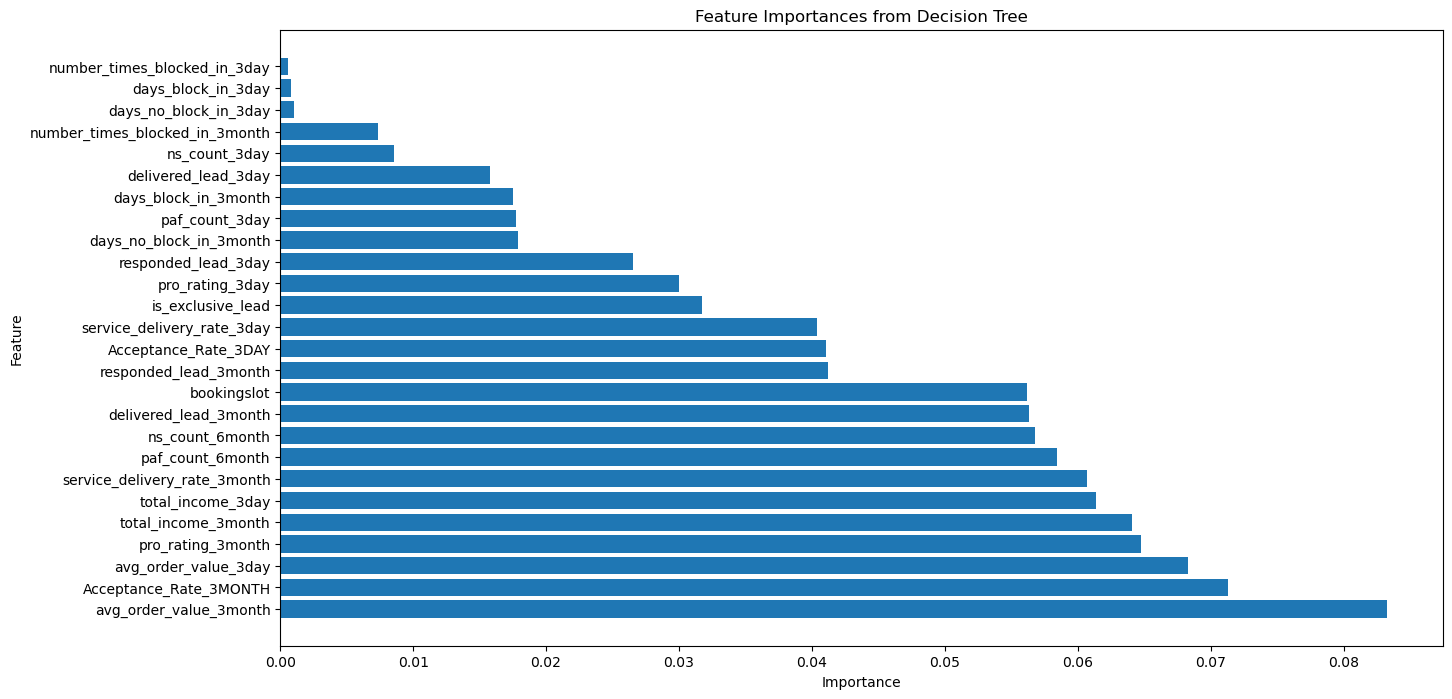

Important features based on Decision Tree:
                         Feature  Importance
8         avg_order_value_3month    0.083294
20        Acceptance_Rate_3MONTH    0.071304
19          avg_order_value_3day    0.068322
3              pro_rating_3month    0.064783
4            total_income_3month    0.064074
15             total_income_3day    0.061362
2   service_delivery_rate_3month    0.060680
22              paf_count_6month    0.058462
23               ns_count_6month    0.056774
1          delivered_lead_3month    0.056349
24                   bookingslot    0.056192
0          responded_lead_3month    0.041182
21          Acceptance_Rate_3DAY    0.041067
13    service_delivery_rate_3day    0.040407
25             is_exclusive_lead    0.031760
14               pro_rating_3day    0.030020
10           responded_lead_3day    0.026568
5        days_no_block_in_3month    0.017897
11                paf_count_3day    0.017762
6           days_block_in_3month    0.017505
12          

In [43]:
# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Get the feature importances
feature_importances = decision_tree_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by the importances
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Filter features with at least 1% importance
important_features_tree = feature_importances_df[feature_importances_df['Importance'] >= 0.01]

# Plotting all feature importances
plt.figure(figsize=(15, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

print("Important features based on Decision Tree:")
print(important_features_tree)
print(f"Number of important features in Decision Tree: {len(important_features_tree)}")

In [44]:
# Convert the important features to lists
important_features_logistic_list = important_features_logistic.index.values.tolist()
important_features_tree_list = important_features_tree['Feature'].values.tolist()

# Find the intersection of both lists
combined_important_features_union = list(set(important_features_logistic_list) | 
                                                set(important_features_tree_list))

print("Combined important features (Union):")
display(combined_important_features_union)
print(f"Total number of combined important features (Intersection): {len(combined_important_features_union)}")

Combined important features (Union):


['paf_count_6month',
 'paf_count_3day',
 'responded_lead_3day',
 'is_exclusive_lead',
 'days_block_in_3month',
 'avg_order_value_3month',
 'delivered_lead_3day',
 'total_income_3month',
 'bookingslot',
 'total_income_3day',
 'pro_rating_3day',
 'ns_count_3day',
 'Acceptance_Rate_3DAY',
 'days_no_block_in_3month',
 'delivered_lead_3month',
 'avg_order_value_3day',
 'pro_rating_3month',
 'service_delivery_rate_3month',
 'number_times_blocked_in_3month',
 'days_no_block_in_3day',
 'ns_count_6month',
 'service_delivery_rate_3day',
 'Acceptance_Rate_3MONTH',
 'responded_lead_3month']

Total number of combined important features (Intersection): 24


## final data

In [45]:
# Filter the original training and test sets
X_train = X_train[combined_important_features_union]
X_test = X_test[combined_important_features_union]

# Filter the scaled training and test sets
X_train_scaled = X_train_scaled[combined_important_features_union]
X_test_scaled = X_test_scaled[combined_important_features_union]

# Filter the upsampled, downsampled, and SMOTE sets
X_train_upsample = X_train_upsample[combined_important_features_union]
X_train_downsample = X_train_downsample[combined_important_features_union]
X_train_smote = X_train_smote[combined_important_features_union]

# Filter the scaled and upsampled, downsampled, and SMOTE sets
X_train_upsample_scaled = train_upsampled_scaled[combined_important_features_union]
X_train_downsample_scaled = train_downsampled_scaled[combined_important_features_union]
X_train_smote_scale_scaled = train_smote_scaled[combined_important_features_union]

<a name='9'></a>

# train

## Compare base models

In [51]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
logistic_model = LogisticRegression(random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Perform cross-validation for each model
models = {'Logistic Regression': logistic_model, 
          'Decision Tree': decision_tree_model, 
          'Random Forest': random_forest_model, 
          'XGBoost': xgb_model}

for name, model in models.items():
    if name == 'Logistic Regression':
        score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    else:
        score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    print(f"Results for {name}:")
    print(f"ROC AUC: {score}")
    print("------")

Results for Logistic Regression:
ROC AUC: 0.6562891309971086
------
Results for Decision Tree:
ROC AUC: 0.527545038303871
------
Results for Random Forest:
ROC AUC: 0.5712726459871684
------
Results for XGBoost:
ROC AUC: 0.6327368288522648
------


## Compare final models and datasets

In [47]:
# Initialize the XGBoost model for resampled datasets
lr= LogisticRegression(random_state=42)

# Datasets
datasets = {
    'Original': (X_train_scaled, y_train),
    'Upsampled': (X_train_upsample_scaled, y_train_upsample),
    'Downsampled': (X_train_downsample_scaled, y_train_downsample),
    'SMOTE': (X_train_smote, y_train_smote)
}

# To store results
results = {}

# Loop through each dataset
for name, (X, y) in datasets.items():
   
    # Fit the model
    lr.fit(X, y)
    
    # Make predictions on the test set
    y_pred = lr.predict(X_test)
    y_pred_prob = lr.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    
    # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for ROC AUC
    f1 = f1_score(y_test, y_pred)
    results[name] = {'ROC AUC': roc_auc, 'F1 Score': f1}

# Display the results
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("------")

Results for Original:
ROC AUC: 0.5071993016873614
F1 Score: 0.008678881388621022
------
Results for Upsampled:
ROC AUC: 0.5069334672668449
F1 Score: 0.009394081728511038
------
Results for Downsampled:
ROC AUC: 0.5063428622062643
F1 Score: 0.008742107819329771
------
Results for SMOTE:
ROC AUC: 0.5704799895111062
F1 Score: 0.002335084646818447
------


In [48]:
# Initialize the XGBoost model for resampled datasets
xgb_model= XGBClassifier(random_state=42)

# Datasets
datasets = {
    'Original': (X_train, y_train),
    'Upsampled': (X_train_upsample, y_train_upsample),
    'Downsampled': (X_train_downsample, y_train_downsample),
    'SMOTE': (X_train_smote, y_train_smote)
}

# To store results
results = {}

# Loop through each dataset
for name, (X, y) in datasets.items():
   
    # Fit the model
    xgb_model.fit(X, y)
    
    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test)
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    
    # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for ROC AUC
    f1 = f1_score(y_test, y_pred)
    results[name] = {'ROC AUC': roc_auc, 'F1 Score': f1}

# Display the results
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("------")

Results for Original:
ROC AUC: 0.6296302981217257
F1 Score: 0.0011547344110854503
------
Results for Upsampled:
ROC AUC: 0.626905382954205
F1 Score: 0.02457466918714556
------
Results for Downsampled:
ROC AUC: 0.6285147490081077
F1 Score: 0.03095975232198142
------
Results for SMOTE:
ROC AUC: 0.632741378136549
F1 Score: 0.002288329519450801
------


## final model hypertuning

In [52]:
best_score = 0  # Initialize the best score
iteration = 0  # Initialize the iteration counter

# Define the objective function
def objective(params):
    global best_score  # Declare best_score as global to update it
    global iteration  # Declare iteration as global to update it
    iteration += 1  # Increment the iteration counter
    
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        min_child_weight=int(params['min_child_weight']),
#         scale_pos_weight=(0.798 / 0.202),
        random_state=42
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train_smote, y_train_smote, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    if score > best_score:
        best_score = score
        print(f"New best score at iteration {iteration}: {best_score}")
        display("Best parameters so far:", params)
    
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'max_depth': hp.quniform('max_depth', 3, 14, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Initialize a trials object
trials = Trials()

# Run the hyperparameter optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

New best score at iteration 1: 0.8991610190043605                                                                      
  0%|                                                                          | 0/100 [00:05<?, ?trial/s, best loss=?]

'Best parameters so far:'

{'colsample_bytree': 0.7592122388662205,
 'gamma': 0.010042274256288175,
 'learning_rate': 0.1943909645471352,
 'max_depth': 4.0,
 'min_child_weight': 5.0,
 'n_estimators': 259.0,
 'subsample': 0.7092598708853596}

New best score at iteration 3: 0.901357620038944                                                                       
  2%|▉                                              | 2/100 [00:46<28:54, 17.70s/trial, best loss: -0.8991610190043605]

'Best parameters so far:'

{'colsample_bytree': 0.4684151532844618,
 'gamma': 0.4360504834157459,
 'learning_rate': 0.14424522366415768,
 'max_depth': 5.0,
 'min_child_weight': 5.0,
 'n_estimators': 483.0,
 'subsample': 0.915078779334169}

New best score at iteration 4: 0.9071648889989332                                                                      
  3%|█▍                                              | 3/100 [01:13<26:29, 16.39s/trial, best loss: -0.901357620038944]

'Best parameters so far:'

{'colsample_bytree': 0.6229017447680121,
 'gamma': 0.015257015763324278,
 'learning_rate': 0.05783485357411009,
 'max_depth': 12.0,
 'min_child_weight': 4.0,
 'n_estimators': 433.0,
 'subsample': 0.9108992460384642}

New best score at iteration 13: 0.9095530508357058                                                                     
 12%|█████▌                                        | 12/100 [04:20<27:48, 18.96s/trial, best loss: -0.9071648889989332]

'Best parameters so far:'

{'colsample_bytree': 0.7326279449159114,
 'gamma': 0.022046335610141132,
 'learning_rate': 0.040468092425232166,
 'max_depth': 11.0,
 'min_child_weight': 2.0,
 'n_estimators': 205.0,
 'subsample': 0.6129673453883452}

 25%|███████████▌                                  | 25/100 [11:17<33:53, 27.12s/trial, best loss: -0.9095530508357058]


KeyboardInterrupt: 

## threshold, metrics

In [ ]:
def evaluate_thresholds_metrics(model, X, y, thresholds):
    results = []

    for threshold in thresholds:
        y_pred = (model.predict_proba(X)[:, 1] > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        f1_score= 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


        results.append({
            'Threshold': threshold,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall,
            'FPR':fpr,
            'Accuracy': accuracy,
            'F1':f1_score,
            'Total_score':(tp*400)+(tn*0)+(fp*(-200))+(fn*(-150))
        })
        
        df=pd.DataFrame(results)
        df.sort_values('F1',ascending=False,inplace=True)
    return df


# Example usage of evaluate_thresholds_metrics function
threshold_values = np.arange(0, 1, 0.01)  # You can adjust the threshold values
